# Take a look at Scania Truck data.
[Database hosted at UCI Machine Learning Repository Site](http://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks#)

There are no label errors. However, nearly every row is missing some kind of measurement. Will need to impute the data one way or another, as dropping rows with any missing measurements leaves only 691 of 60k rows.

In [77]:
import sys

# Data Containers
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing: standardizing, undersampling, and oversampling, gridsearch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,\
cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

#Pipeline Experimentation
from sklearn.pipeline import make_pipeline

# Models: dummy, kNN, logistic regression, Naive Bayes, SVM
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation metrics
# ROC curve
# Proprietary cost function
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
auc, log_loss, confusion_matrix, f1_score, make_scorer, roc_auc_score, roc_curve

In [3]:
import sklearn
sklearn.__version__

'0.20.0'

In [4]:
def get_nan_frac_cols(df, cutoff = 0.25, graph=True):
    '''
    Returns column labels for columns with a NaN values fraction >= a cutoff fraction.
    Intended use is to visualize how prevalent NaN values are in a dataset.
    ---
    Parameters
    df: Pandas dataframe. Each column represents a feature and its data for all observations.
    cutoff: decimal value, the acceptable fraction of data that can be NaN
    graph: bool, visualizes the data if True
    
    Returns
    List of dataframe column labels that have NaN fraction > cutoff fraction
    '''
    nan_frac_vec, cols_high_nan = [], []
    
    for column in df.columns:
        nan_frac = df[column][df[column].isnull()].size/df.shape[0]
        nan_frac_vec.append(nan_frac)

        if nan_frac >= cutoff:
            cols_high_nan.append(column)
            
    if graph:
        sns.scatterplot(range(df.shape[1]),nan_frac_vec, alpha = 0.9, label='data')
        plt.plot(range(df.shape[1]), np.ones(df.shape[1])*cutoff,'r-', label='Cutoff Threshold')
        plt.legend(loc='best')
        plt.title('Data by column with {}% cutoff'.format(100*cutoff))
        plt.ylabel('Fraction of Values that are NaN')
        plt.xlabel('Column position')
    
    return cols_high_nan

In [5]:
def fit_score_model(features,target,model=DummyClassifier, metric=accuracy_score, params = {}):
    '''
    Function for creating a model instance and getting the desired classification error metric.
    Defaults to sklearn dummy classifier with default parameters
    ----
    Inputs:
    features: array-like object containing features for model fitting
    target: 1-D array-like object cotaining labels for model fitting
    model: sklearn model class or similar that estimates the target value from training data
    metric: function for evaluating an estimator against the true labels.
            Should take arguments (y_true, y_pred) in that order.
    
    Returns:
    score: float value output by metric
    '''
    # Initiate model instance with relevant parameters
    instance = model(**params)
    
    instance.fit(features,target)
    
    # Determine whether to use labels or probabilities when evaluating model
    proba_based_metrics = [log_loss]
    
    if metric in proba_based_metrics:
        return metric(target, instance.predict_proba(features))
    else:
        return metric(target, instance.predict(features))

In [87]:
def scania_score(y_true,y_pred):
    '''
    Calculates Scania's custom score for APS classification problem in heavy trucks.
    Type 2 errors are more heavily penalized, and a lower score is better.
    
    Score is 10*(no. of false positives) + 500*(no. of false negatives)
    Type 1 error represents a mechanic performing an unnecessary inspection.
    Type 2 error represents a failure to identify a faulty truck, possibly resulting in a break-down.
    ---
    Inputs:
    y_true,y_pred: array-like objects of equal length representing true and predicted labels.
    
    Returns:
    float value (>= 0) representing cost of Type 1 and 2 errors in classification.
    '''
    confmat = confusion_matrix(y_train, y_pred)
    
    return confmat[0,1]*10 + confmat[1,0]*500

### Read in data and manipulation

In [7]:
# Original dataset has some text at the top of the csv, above the headers.
# File below has that text removed, leaving only header row and data.
aps = pd.read_csv('./aps_failure_training_set_no_headers.csv')

In [8]:
# Nearly all data enters the dataframe as a string object.
aps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [9]:
# Checking for weird labels
print('Label values:', aps['class'].unique())
mask = aps['class']=='neg'
print('Negative class observations:',aps[mask]['class'].shape[0] )
print('Positive class observations:', aps[~mask]['class'].shape[0])

Label values: ['neg' 'pos']
Negative class observations: 59000
Positive class observations: 1000


In [10]:
# Create new dataframe for EDA
# For each column in dataframe, make that column numeric

X = aps.iloc[:,1:].copy(deep=True)
y = aps['class']

In [11]:
# Convert target variable to numeric

print('Pre-conversion y', y.dtype, y.value_counts(), sep = '\n')
y = pd.Series([0 if lbl == 'neg' else 1 for lbl in y], name = 'class')
print('Post-conversion y', y.dtype, y.value_counts(), sep = '\n')

Pre-conversion y
object
neg    59000
pos     1000
Name: class, dtype: int64
Post-conversion y
int64
0    59000
1     1000
Name: class, dtype: int64


In [12]:
X.replace('na', np.nan, inplace=True)

In [13]:
# Convert columns to numeric.
print(X.info())
for column in X.columns:
    X[column]= pd.to_numeric(X[column], errors = 'raise')
    
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: int64(1), object(169)
memory usage: 77.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: float64(169), int64(1)
memory usage: 77.8 MB
None


In [15]:
'''        LOOK AT NUMBER OF UNIQUE VALUES PER FEATURE. WHAT DOES THIS TELL YOU ABOUT THE FEATURE TYPE?   '''
'''     TRY TO IMPUTE THE MISSING DATA INSTEAD OF JUST REPLACING. WHAT CAN YOU LEARN?                   '''
ssi = SimpleImputer(missing_values=np.nan, strategy='mean')

#Fit on TRAINING DATA

## Dealing with NaN:
Current options:
* drop columns with mostly nan, then drop any row with nan. How many observations do you lose?  
* experiment with sklearn.preprocessing.Imputer
* read sklearn [imputation guide](http://scikit-learn.org/stable/modules/impute.html)
* take mean values
* use kNN with features that aren't null
* determine on which features it would be reasonable to impute

Columns above threshold: 28
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54143 entries, 0 to 59999
Columns: 142 entries, aa_000 to eg_000
dtypes: float64(141), int64(1)
memory usage: 59.1 MB


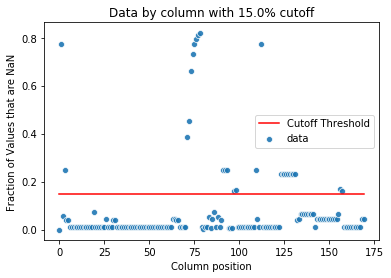

In [16]:
#Dropping idea: Remove columns w/ NaN percent above a threshold, then drop all corresponding rows
nan_cols = get_nan_frac_cols(X, 0.15, graph=True)
print('Columns above threshold:',len(nan_cols))

X_no_nan = X.drop(nan_cols, axis=1).dropna()
X_no_nan.info()

[]

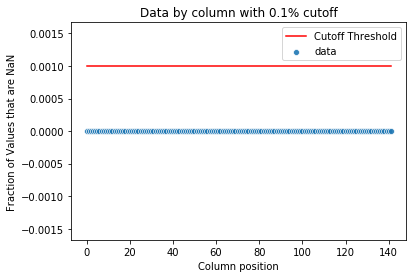

In [17]:
# Visualize the effect
get_nan_frac_cols(X_no_nan, 0.001);

In [18]:
# Check that we still have a good amount of negative and positive classes
y_no_nan = y[X_no_nan.index].reset_index(drop=True)
X_no_nan = X_no_nan.reset_index(drop=True)
print('Total remaining observations:',y_no_nan.shape[0])
print('Number of negative class:', np.sum(y_no_nan==0))
print('Number of positive class:', y_no_nan[y_no_nan==1].sum())

Total remaining observations: 54143
Number of negative class: 53738
Number of positive class: 405


Dropping high columns with a high percentage of `NaN` values, then culling the observations with any `NaN` value still leaves 54,143 observations, down from 60,000. We also retained 142 of the 170 featurs. However, of the original 1000 positive examples, only 405 remain. The negative class still has 53,738 observations.  

Percent loss, by class, when dropping NaN values:
* Positive class: 59.5%
* Negative class:  0.7%  

Takeaways:  
1) I still have enough examples to train on.  
2) Since the lack of measurements disproportionately affects one class, it could be that the number of missing values is correlated with the class type, and thus should become a feature. To incorporate this, I'd need to impute values (strategically) for the observations that were eliminated.  
3) Look at imputing the data instead of running a `pandas.DataFrame.dropna()` after removing high-NaN columns.

## Adding database to SQL
Because I don't think it's efficient to write out the 170 columns with their respective types, so I'm going to try to manipulate the columns list into an SQL table creation command.

In [102]:
test = tuple(column + ' col_type' for column in X.columns[:2])
print(test)

('aa_000 col_type', 'ab_000 col_type')


In [103]:
', '.join(thing for thing in test)

'aa_000 col_type, ab_000 col_type'

## Testing Classifiers on Data
Two approach philosophies:
* See which naive model has best performance over K folds, then tune that model to optimal performance.
* Tune every model, to include the number of folds in the data, then evaluate those models over 10 folds.

## Split stratified data into train/holdout, then split training data into stratified train/test folds

The SKLearn method StratifiedShuffleSplit is used to split the data into a randomized training and holdout set that maintains the percentage of the positive class in the original data. From there, StratifiedKFolds is used to break the training set into cross-validation folds for assessing model performance.

In [ ]:
# This cell works just fine, in the event that the y classes are not stratified. Don't use for now.
# X_train, X_test, y_train, y_test = train_test_split(X_no_nan,y_no_nan, test_size = 0.20, random_state = 42)
# np.random.seed(42)

In [19]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.20, random_state=42)

In [20]:
for train_index, holdout_index in sss.split(X_no_nan,y_no_nan):
    #print("TRAIN:", train_index, "TEST:", holdout_index)
    X_train = X_no_nan.values[train_index]
    X_test = X_no_nan.values[holdout_index]
    y_train = y_no_nan.values[train_index]
    y_test = y_no_nan.values[holdout_index]
    
    #Check that the train/test split is disjoint
    assert(not set(train_index).intersection(set(holdout_index)))

### Naive Performance of Classifiers
Grab small subsection of data while setting up the pipeline so as not to make the runtime too large.  

'''   EXPERIMENT WITH MAKING A PIPELINE OBJECT .  '''

In [31]:
# Create stratified folds for cross-validation
skf = StratifiedKFold(n_splits=10, random_state=42)

In [32]:
# SkLearn Dummy classifier baseline
np.mean(cross_val_score(DummyClassifier(),X_train,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.502156024656897

In [33]:
# Absolute baseline: Predicting everything as negative
all_neg = np.zeros(len(y_train))
print(roc_auc_score(y_train, all_neg))
print(scania_score(y_train,all_neg))

0.5
162000


In [25]:
# Decision Tree
np.mean(cross_val_score(DecisionTreeClassifier(),X_train,y_train, cv=skf, scoring='roc_auc'))

0.8041831213390006

In [62]:
# K Nearest Neighbors
def iterate_k_for_KNN(X, y, start_k, stop_k, metric='roc_auc',use_cv=5):
    '''
    Tests k-nearest neighbors algorithm for provided range of k.
    Returns k value that optimizes for the provided classification error metric.
    '''
    best_k, best_score = None, 0
    for k in range(start_k,stop_k):
        knn_params = {'n_neighbors':k}
        score = np.mean(cross_val_score(KNeighborsClassifier(**knn_params),X,y,
                            cv=use_cv, scoring = metric))    
        print(k,score)

        if score > best_score:
            best_k = k
            best_score = score

    return(best_k,best_score)

In [64]:
iterate_k_for_KNN(X_train, y_train, 1, 11, metric='roc_auc', use_cv=skf)

1 0.7377864368563513
2 0.7819243441920952
3 0.8088115431178498
4 0.822014699507285
5 0.833807743344118
6 0.8518036149174932
7 0.8577166245497543
8 0.8651250158599252
9 0.8755572230504628
10 0.8844660844311927


(10, 0.8844660844311927)

In [45]:
# Logistic Regression
lgr_params = {'C':1, 'solver':'liblinear'}
np.mean(cross_val_score(LogisticRegression(**lgr_params),X_train,y_train,
                        cv=skf, scoring = 'roc_auc'))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9372424524378467

In [41]:
# Naive Bayes, Gaussian
gnb_params = {}
np.mean(cross_val_score(GaussianNB(**gnb_params),X_train,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.9496054072652556

In [42]:
# Naive Bayes, Multinomial
#mnb_params = {'alpha':1.0}
mnb_params = {}
np.mean(cross_val_score(MultinomialNB(**mnb_params),X_train,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.6305736402757512

In [43]:
# Naive Bayes, Bernoulli
#bnb_params = {'alpha':1.0}
bnb_params = {}
np.mean(cross_val_score(BernoulliNB(**bnb_params),X_train,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.9347346238025758

In [47]:
# Random Forest Classifier
rfc_params = {}
np.mean(cross_val_score(RandomForestClassifier(**rfc_params), X_train, y_train,
                       cv=skf, scoring='roc_auc'))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The de

0.9364471322612025

In [50]:
# Gradient Boosting Classifier
gb_params={}
np.mean(cross_val_score(GradientBoostingClassifier(), X_train, y_train,
                       cv = skf, scoring = 'roc_auc'))

0.9544853740651454

In [52]:
# Linear SVM
# kernels: stick with 'linear'
svc_params = {}
np.mean(cross_val_score(LinearSVC(**svc_params), X_train, y_train,
                       cv = skf, scoring = 'roc_auc'))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7049580989588841

In [57]:
'''
SVM
really fucking slow
kernel options: 'linear', 'poly', 'rbf', 'sigmoid'
paramters: all: 'C'
           'gamma': rbr, poly, sigmoid
           'degree': poly
           'coef0': poly, sigmoid
'''
# svc_params = {'gamma':'scale'}
# np.mean(cross_val_score(SVC(**svc_params),X_train,y_train,
#                         cv=skf, scoring = 'roc_auc'))

"\nSVM\nreally fucking slow\nkernel options: 'linear', 'poly', 'rbf', 'sigmoid'\nparamters: all: 'C'\n           'gamma': rbr, poly, sigmoid\n           'degree': poly\n           'coef0': poly, sigmoid\n"

## Naive Classifiers using Scaled Data

In [60]:
ssx = StandardScaler()
X_train_scaled = ssx.fit_transform(X_train)
X_test_scaled = ssx.transform(X_test)

In [61]:
# DECISION TREE
np.mean(cross_val_score(DecisionTreeClassifier(),X_train_scaled,y_train, cv=skf, scoring='roc_auc'))

0.8087750983315359

In [74]:
# NEAREST NEIGHBORS
iterate_k_for_KNN(X_train_scaled, y_train, 1, 11, metric='roc_auc', use_cv=skf)

1 0.776732696821671
2 0.8134981179555499
3 0.8364070969640579
4 0.8502375464343365
5 0.8639242433053493
6 0.8745374629053974


KeyboardInterrupt: 

In [66]:
# Logistic Regression
lgr_params = {'C':1, 'solver':'liblinear'}
np.mean(cross_val_score(LogisticRegression(**lgr_params),X_train_scaled,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.9203227759098311

In [67]:
# Naive Bayes, Gaussian
gnb_params = {}
np.mean(cross_val_score(GaussianNB(**gnb_params),X_train_scaled,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.9457376230906412

In [69]:
# Naive Bayes, Bernoulli
#bnb_params = {'alpha':1.0}
bnb_params = {}
np.mean(cross_val_score(BernoulliNB(**bnb_params),X_train_scaled,y_train,
                        cv=skf, scoring = 'roc_auc'))

0.9093221556105366

In [70]:
# Random Forest Classifier
rfc_params = {}
np.mean(cross_val_score(RandomForestClassifier(**rfc_params), X_train_scaled, y_train,
                       cv=skf, scoring='roc_auc'))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The de

0.9350398502646847

In [71]:
# Gradient Boosting Classifier
gb_params={}
np.mean(cross_val_score(GradientBoostingClassifier(), X_train_scaled, y_train,
                       cv = skf, scoring = 'roc_auc'))

0.9627331849549225

In [72]:
# Linear SVM
# kernels: stick with 'linear'
svc_params = {}
np.mean(cross_val_score(LinearSVC(**svc_params), X_train_scaled, y_train,
                       cv = skf, scoring = 'roc_auc'))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8936939615978347

In [75]:
'''
SVM
really fucking slow
kernel options: 'linear', 'poly', 'rbf', 'sigmoid'
paramters: all: 'C'
           'gamma': rbr, poly, sigmoid
           'degree': poly
           'coef0': poly, sigmoid
'''
# svc_params = {}
# np.mean(cross_val_score(SVC(**svc_params),X_train,y_train,
#                         cv=skf, scoring='roc_auc'))

"\nSVM\nreally fucking slow\nkernel options: 'linear', 'poly', 'rbf', 'sigmoid'\nparamters: all: 'C'\n           'gamma': rbr, poly, sigmoid\n           'degree': poly\n           'coef0': poly, sigmoid\n"

In [76]:
# For MVP purposes, training vanilla GBM on X_train
grb = GradientBoostingClassifier().fit(X_train_scaled, y_train)
y_pred = grb.predict(X_test_scaled)

NameError: name 'roc_curve' is not defined

In [90]:
y_pred_whole = grb.predict(ssx.transform(X_no_nan))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


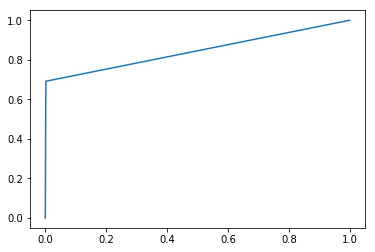

In [81]:
fpr, tpr, ths = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr)

In [89]:
# Test set results
confusion_matrix(y_test, y_pred)

array([[10729,    19],
       [   25,    56]])

In [91]:
# for mvp
confusion_matrix(y_no_nan, y_pred_whole)

array([[53715,    23],
       [   64,   341]])

In [ ]:
"""
Make a dictionary of models
"""

# Pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression( penalty = 'l1', random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression( penalty = 'l2', random_state=123, solver = 'lbfgs')),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
    'linsvc' : make_pipeline(StandardScaler(), LinearSVC(random_state=123)),
    'rbfsvc' : make_pipeline(StandardScaler(), SVC(kernel='rbf'))
}

"""
Make a dictionary of dictionaries
Each sub dictionary is the hyperparameters to tune for each model
"""
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [50, 100, 150, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gradientboostingclassifier__max_depth': [1, 2, 3, 4, 5]
}

linsvc_hyperparameters = {
    'C': [1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3]
}

rbfsvc_hyperparameters = {
    'C': [1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3]
    'gamma' : [1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3]
}
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters, 
    'l2' : l2_hyperparameters, 
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'linsvc' : linsvc
}

"""
Grid search over each model, returning the best estimator 
(by default I believe, may need to mess with refit option)
"""
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], scoring = 'neg_log_loss' cv=10)

    # Fit model on X_train, y_train
    model.fit(X_train, y_train)    
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model    

    
"""
Print out AUC scores for each model
"""
    
for name, model in fitted_models.items():
    pred = fitted_models[name].predict_proba(X_test)
    # Get just the prediction for the positive class (1)
    pred = [p[1] for p in pred]
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    # Calculate AUROC
    print(name, auc(fpr, tpr))